# Create Confusion Matrix

In [1]:
from BCM_dataset_v2 import bcmDataset
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from collect_dataset import *


Dataset version: 5


In [6]:
# Load a previously trained model

from BCM_dataset_v2 import concat_train_test_datasets


model_loaded = torch.jit.load('trained_models/ft_final_ft_file_2022-09-20_15-38-11')
model_loaded.eval()

# Create a dataset
#ds = bcmDataset('data/bcm/4.npy', class_id = 4, window_size = 3, stride = 3, MFCC_stride = 0.032)
loso_datasets = create_loso_datasets()
ft_datasets = create_ft_datasets()
_, ds = concat_train_test_datasets(ft_datasets[0])



loso_datasets:

train

0
bcm_behaviour_data_multi_subject/subject2/2022-11-09_14-34-16
bcm_behaviour_data_multi_subject/subject2/2022-11-09_14-52-7
bcm_behaviour_data_multi_subject/subject2/2022-11-09_14-15-6
bcm_behaviour_data_multi_subject/subject2/2022-11-09_13-56-0
bcm_behaviour_data_multi_subject/subject3/2022-11-09_15-47-1
bcm_behaviour_data_multi_subject/subject3/2022-11-09_16-26-13
bcm_behaviour_data_multi_subject/subject3/2022-11-09_15-27-14
bcm_behaviour_data_multi_subject/subject3/2022-11-09_16-7-9
1
bcm_behaviour_data_multi_subject/subject3/2022-11-09_15-47-1
bcm_behaviour_data_multi_subject/subject3/2022-11-09_16-26-13
bcm_behaviour_data_multi_subject/subject3/2022-11-09_15-27-14
bcm_behaviour_data_multi_subject/subject3/2022-11-09_16-7-9
bcm_behaviour_data_multi_subject/subject1/2022-09-20_15-38-11
bcm_behaviour_data_multi_subject/subject1/2022-09-20_14-58-39
bcm_behaviour_data_multi_subject/subject1/2022-09-20_15-18-27
bcm_behaviour_data_multi_subject/subject1/2022-09-2

In [9]:

preds = np.zeros(len(ds))
y = np.zeros(len(ds))

print(len(ds))

for i in range(0, len(ds)):
    # Remeber to insert empty/None dimension to test a single datapoint!!!!!!!!!
    test = ds[i][0]
    test = test[None,:,:]
    preds[i] = model_loaded(test).argmax()
    y[i] = ds[i][1].argmax()
    # If i is a multiple of 1000, print the progress
    if i%1000 == 0:
        print(i)
    
    
# Cell takes approx 7 mins to run (47 mins for LOSO)




167355
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000


In [ ]:

for i in range(0, len(ds)):
    # Remeber to insert empty/None dimension to test a single datapoint!!!!!!!!!
    test = ds[i][0]
    test = test[None,:,:]
    preds[i] = model_loaded(test).argmax()
    y[i] = ds[i][1].argmax()
    
    
# Cell takes approx 7 mins to run (47 mins for LOSO)




0.9241432882196529


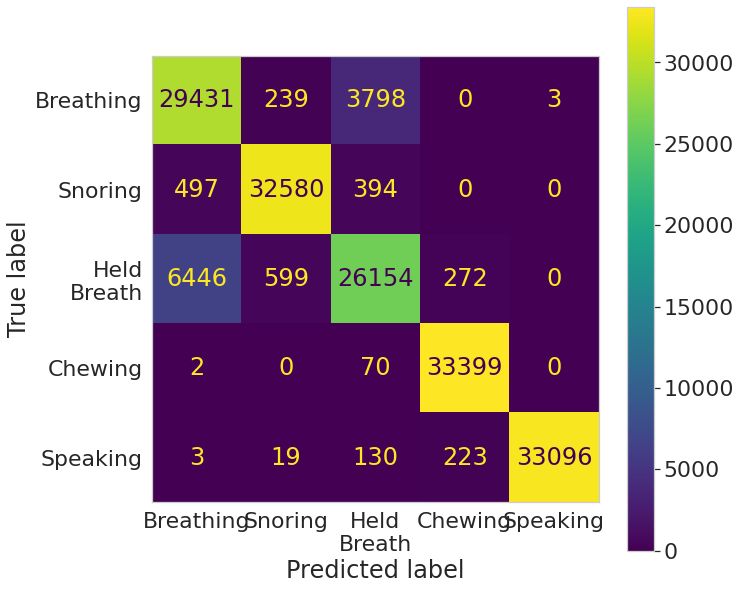

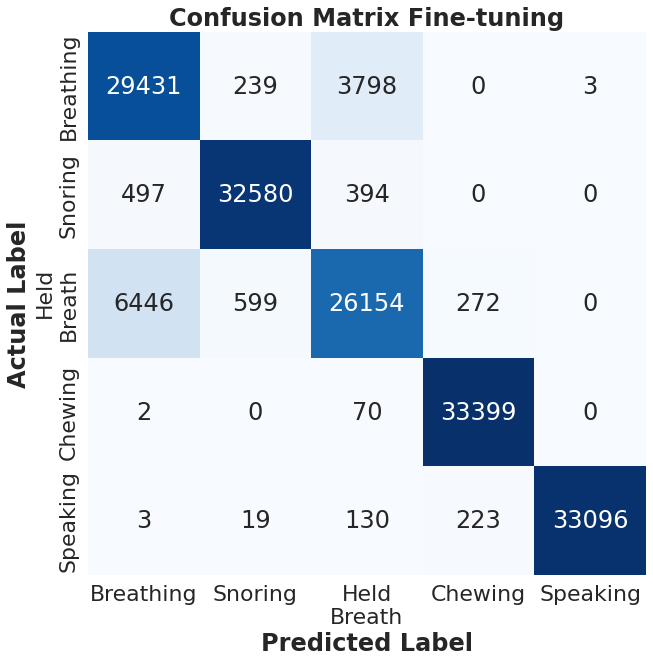

In [11]:
import seaborn as sns
#np.save('preds', preds)
#np.save('y', y)

#preds = np.load('preds.npy')
#y = np.load('y.npy')

conf_mat = confusion_matrix(y, preds)
fig, ax = plt.subplots(figsize=(10, 10))

# Configure seaborn with font size, etc.
sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})
plt.xticks(rotation=60)
# Change the color map
sns.set_palette("mako")



cm = confusion_matrix(y, preds, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Breathing','Snoring','Held\nBreath','Chewing','Speaking'])

fig.patch.set_facecolor('white')



disp.plot(ax = ax)

# Calculate accuracy
acc = (conf_mat[0,0] + conf_mat[1,1] + conf_mat[2,2] + conf_mat[3,3] + conf_mat[4,4]) / conf_mat.sum()
print(acc)



# Get the conf matrix data, and plot using seaborn heatmap without the colorbar

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Breathing','Snoring','Held\nBreath','Chewing','Speaking'], yticklabels=['Breathing','Snoring','Held\nBreath','Chewing','Speaking'], 
            cmap = 'Blues',
            cbar=False)
plt.ylabel('Actual Label', fontweight='bold')
plt.xlabel('Predicted Label',fontweight='bold')
plt.title('Confusion Matrix Fine-tuning', fontweight='bold')

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

# Traceable dataset

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import tracemalloc
from scipy import signal

In [2]:
# Load the jitted model
from BCM_dataset_v2 import concat_train_test_datasets
model_loaded = torch.jit.load('trained_models/final_loso_val_subject1')
model_loaded.eval()

Dataset version: 5


RecursiveScriptModule(
  original_name=LSTM_Model
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (flatten): RecursiveScriptModule(original_name=Flatten)
  (fc): RecursiveScriptModule(original_name=Linear)
  (output): RecursiveScriptModule(original_name=Sigmoid)
  (sm): RecursiveScriptModule(original_name=Softmax)
  (loss): RecursiveScriptModule(original_name=CrossEntropyLoss)
  (accuracy): RecursiveScriptModule(original_name=Accuracy)
  (val_accuracy): RecursiveScriptModule(original_name=Accuracy)
)

In [3]:
raw_file = h5py.File('bcm_activity_dataset/2022-09-20_14-58-39.hdf5', 'r')
data_full = np.array(raw_file['DAQ970A']['data'])
data_ear_1 = data_full[:,0]
data_ear_2 = data_full[:,1]
labels = data_full[:,3]

last_decoded = -500000
label_index_list = [] # List of the indices of the labels
for i, j in enumerate(np.rint(labels)):
    
    if int(j) and (i > last_decoded+50000*8):
        print(f"i: {i}")
        print(f"Time: {i/50000} s")
        last_decoded = i
        
        label_index_list.append(i)

i: 19492
Time: 0.38984 s
i: 519489
Time: 10.38978 s
i: 1019486
Time: 20.38972 s
i: 1519483
Time: 30.38966 s
i: 2019481
Time: 40.38962 s
i: 2519478
Time: 50.38956 s
i: 3019475
Time: 60.3895 s
i: 3519472
Time: 70.38944 s
i: 4019470
Time: 80.3894 s
i: 4519467
Time: 90.38934 s
i: 5020452
Time: 100.40904 s
i: 5520449
Time: 110.40898 s
i: 6020446
Time: 120.40892 s
i: 6520443
Time: 130.40886 s
i: 7020440
Time: 140.4088 s
i: 7520438
Time: 150.40876 s
i: 8020435
Time: 160.4087 s
i: 8520432
Time: 170.40864 s
i: 9020429
Time: 180.40858 s
i: 9520427
Time: 190.40854 s
i: 10022045
Time: 200.4409 s
i: 10522042
Time: 210.44084 s
i: 11022039
Time: 220.44078 s
i: 11522036
Time: 230.44072 s
i: 12022033
Time: 240.44066 s
i: 12522031
Time: 250.44062 s
i: 13022028
Time: 260.44056 s
i: 13522025
Time: 270.4405 s
i: 14022022
Time: 280.44044 s
i: 14522019
Time: 290.44038 s
i: 15023764
Time: 300.47528 s
i: 15523762
Time: 310.47524 s
i: 16009096
Time: 320.18192 s
i: 16523756
Time: 330.47512 s
i: 17023753
Time: 34

In [4]:
index_labels = [] # A list of labels for the indexes in label_index_list

for i in range(6):
    index_labels.extend([0,0,0,1,1,1,2,2,2,-1])

for i in range(18): index_labels.append(3)
index_labels.append(-1)

for i in range(18): index_labels.append(4)
index_labels.append(-1)

labels_np = np.array(index_labels)
labels_np = np.repeat(labels_np, 500000)

labels_np = np.hstack((np.zeros(label_index_list[0]), labels_np))




In [6]:
print(labels_np.shape)
print(data_ear_1.shape)


(49019492,)
(49000000,)


In [5]:
# Create mfccs and labels
fs = 50000
data_mfcc_ear1 = mfcc(data_ear_1, samplerate = fs, nfft = 1600, winlen=0.032, winstep=0.032, numcep=16)
data_mfcc_ear2 = mfcc(data_ear_2, samplerate = fs, nfft = 1600, winlen=0.032, winstep=0.032, numcep=16)
labels_mfcc = labels_np[::1600]

print(data_mfcc_ear1.shape)
print(data_mfcc_ear2.shape)
print(labels_mfcc.shape)


(30625, 16)
(30625, 16)
(30638,)


In [29]:

# Use the model to predict the labels
preds_list_ear1 = []
for i in range(0, len(data_mfcc_ear1)):
    # Remeber to insert empty/None dimension to test a single datapoint!!!!!!!!!
    if i + 93 > len(data_mfcc_ear1):
        break
    
    test = data_mfcc_ear1[i:i+93]
    test = torch.from_numpy(test[None,:,:]).float()
    preds_list_ear1.append(model_loaded(test).argmax())
# Repeat for ear 2
preds_list_ear2 = []
for i in range(0, len(data_mfcc_ear2)):
    # Remeber to insert empty/None dimension to test a single datapoint!!!!!!!!!
    if i + 93 > len(data_mfcc_ear2):
        break
    
    test = data_mfcc_ear2[i:i+93]
    test = torch.from_numpy(test[None,:,:]).float()
    preds_list_ear2.append(model_loaded(test).argmax())


# Takes approx. 8 min. to run on cpu

In [30]:
# Save the predictions from each ear and the labels to files in predictions folder
np.save('predictions/preds_ear1_loso.npy', preds_list_ear1)
np.save('predictions/preds_ear2_loso.npy', preds_list_ear2)
np.save('predictions/labels_loso.npy', labels_mfcc)


In [21]:
# Load the predictions and labels
'''preds_list_ear1 = np.load('predictions/preds_ear1_loso.npy')
preds_list_ear2 = np.load('predictions/preds_ear2_loso.npy')
labels_mfcc = np.load('predictions/labels_loso.npy')'''

preds_list_ear1 = np.load('predictions/preds_ear1_loso.npy')
preds_list_ear2 = np.load('predictions/preds_ear2_ft.npy')
labels_mfcc = np.load('predictions/labels_loso.npy')

In [22]:
# Make a combination of the predictions from ear 1 and ear 2 where the prediction only changes when both ears agree, otherwise it stays the same
preds_combined = []

for i in range(len(preds_list_ear1)):
    if preds_list_ear1[i] == preds_list_ear2[i]:
        preds_combined.append(preds_list_ear1[i])
    else:
        preds_combined.append(preds_combined[-1])
        
        
# Calculate the accuracy of the combined predictions
correct = 0
skipped = 0
for i in range(len(preds_combined)):
    if labels_mfcc[i] == -1:
        skipped += 1
        continue
    if preds_combined[i] == labels_mfcc[i]:
        correct += 1

print(f"Accuracy: {correct/(len(preds_combined)-skipped)}")
# Calculate the accuracy of the predictions from ear 1 and ear 2
correct_ear1 = 0
correct_ear2 = 0

for i in range(len(preds_list_ear1)):
    if preds_list_ear1[i] == labels_mfcc[i]:
        correct_ear1 += 1
    if preds_list_ear2[i] == labels_mfcc[i]:
        correct_ear2 += 1

print(f"Accuracy ear 1: {correct_ear1/(len(preds_combined)-skipped)}")
print(f"Accuracy ear 2: {correct_ear2/(len(preds_combined)-skipped)}")

# Average of 0.9208103 and 0.93015 is 0.92548


Accuracy: 0.9366625199928914
Accuracy ear 1: 0.7684378887506664
Accuracy ear 2: 0.9301581659854274


30533
30533
30533


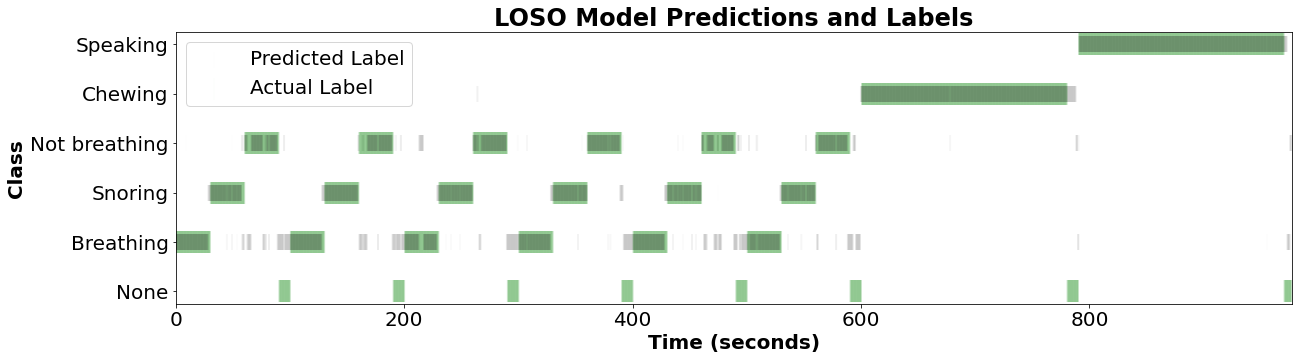

In [23]:
cycle = 2822
gap = 308
seg_len = len(preds_list_ear1) 
seg_pos = 0

w = 1
smoothed_preds_ear1 = np.convolve(np.array(preds_list_ear1), np.ones(w), 'valid') / w
smoothed_preds_ear2 = np.convolve(np.array(preds_list_ear2), np.ones(w), 'valid') / w

#smoothed_preds_ear2 = np.convolve(np.array(preds_combined), np.ones(w), 'valid') / w # Comment out to not use combined predictions_________!!!!!!!!____________!!!!!________________________________________________________________________________

print(len(preds_list_ear1))
print(len(smoothed_preds_ear2))

# Plot preds_list
fig = plt.figure(figsize=(20, 5))
#plt.plot(preds_list_ear1[seg_pos:seg_pos+seg_len])
#plt.plot(preds_list_ear2[seg_pos:seg_pos+seg_len])

# Linear scale for plotting, with 32 ms space between each mfcc
time = np.linspace(0, len(preds_list_ear1)*0.032, len(preds_list_ear1)-(w-1))
print(len(time))

# plt.scatter(range(seg_len), np.round(smoothed_preds_ear1[seg_pos:seg_pos+seg_len]), s=100)
# Matplotlib marker types are: https://matplotlib.org/3.1.1/api/markers_api.html
# Scatter plot marker colors: blue = 'b', 
plt.scatter(time, np.round(smoothed_preds_ear2[seg_pos:seg_pos+seg_len]),c = 'k', alpha=0.005, s=250, marker='|')

# opacity = 0.5
plt.scatter(time, labels_mfcc[seg_pos:seg_pos+seg_len], s=500, c='g', alpha=0.008, marker='|')

# Add the labels of the classes to the y-axis
plt.yticks([-1,0,1,2,3,4], ['None', 'Breathing', 'Snoring', 'Not breathing', 'Chewing', 'Speaking'])
plt.xlim(0,seg_len*0.032)
# Font size
plt.rcParams.update({'font.size': 20})


# Bold typeface
plt.xlabel('Time (seconds)', fontweight='bold')
plt.ylabel('Class', fontweight='bold')
plt.title('LOSO Model Predictions and Labels', fontweight='bold')

# Add legend
plt.legend(['Predicted Label','Actual Label'])
plt.savefig('predictions/loso_preds_labels.png')

plt.show()


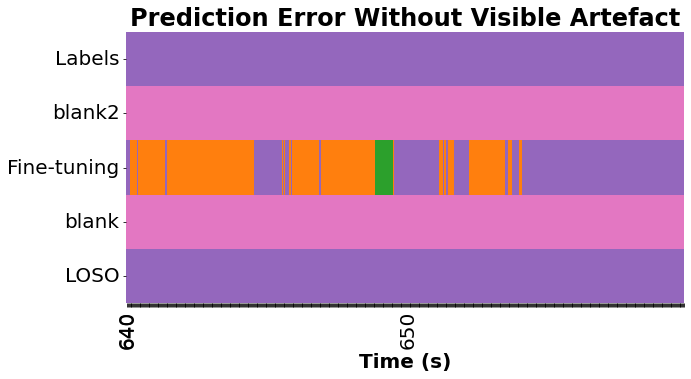

In [31]:



# Alternative way to plot
# Same plot, but using seaborn heatmap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



cycle = 2822
gap = 308
seg_len = 31*20
seg_pos = 31*646


# Linear scale for plotting, with 32 ms space between each mfcc
time = np.linspace(0, len(preds_list_ear1)*0.032, len(preds_list_ear1))


w = 1
smoothed_preds_ear1 = np.convolve(np.array(preds_list_ear1), np.ones(w), 'valid') / w
smoothed_preds_ear2 = np.convolve(np.array(preds_list_ear2), np.ones(w), 'valid') / w #______________________________________________using combined predictions
sns.color_palette("hls", 8)

df = pd.DataFrame()

df['Labels'] = labels_mfcc[seg_pos:seg_pos+seg_len]
# Add a column with zeros to df
df['blank2'] = np.zeros(seg_len)+5
df['Fine-tuning'] = np.round(smoothed_preds_ear1[seg_pos:seg_pos+seg_len])
# Add a column with zeros to df
df['blank'] = np.zeros(seg_len)+5
df['LOSO'] = np.round(smoothed_preds_ear2[seg_pos:seg_pos+seg_len])


# Transpose the dataframe
df = df.T



# set the width and height of the figure
f, ax = plt.subplots(figsize=(10, 5))

# Add labels to the x-axis
xticklabels = []
for i in range(seg_len):
    if i % (10/0.032) <= 1: # if i is a multiple of 10 seconds, add a label, else add an empty string
        xticklabels.append(int((seg_pos*0.032) + i*0.032))
    else:
        xticklabels.append('')

plt.rcParams.update({'font.size': 20})



sns.heatmap(df, cbar=False,cmap = 'tab10', vmin=-1, vmax=8, xticklabels = xticklabels)
# Bold typeface
plt.xlabel('Time (s)', fontweight='bold')
plt.title('Prediction Error Without Visible Artefact', fontweight='bold')
#plt.ylabel('Class', fontweight='bold')
plt.show()





Text(0, 0.5, 'Amplitude')

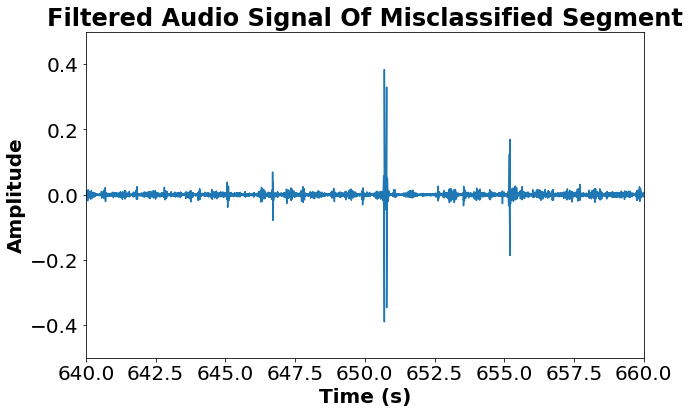

In [28]:
# Plot the raw signal
# Linear scale for plotting, with 32 ms space between each mfcc
time = np.linspace(0, len(data_ear_1)*(1/50000), len(data_ear_1))

import scipy.signal as signal
b, a = signal.butter(5, 20, btype='highpass', fs=50000)
filtered_data = signal.filtfilt(b, a, data_ear_1)



# Set the width and height of the figure
plt.figure(figsize=(10,6))

plt.plot(time, np.array(filtered_data))
#plt.xlim(65,85)
#plt.xlim(210,230)
plt.xlim(640,660)
plt.ylim(-0.5,0.5)

plt.title('Filtered Audio Signal Of Misclassified Segment', fontweight='bold')
plt.xlabel('Time (s)', fontweight='bold')
plt.ylabel('Amplitude', fontweight='bold')

#plt.plot(time, np.array(data_ear_2))

<Figure size 720x432 with 0 Axes>

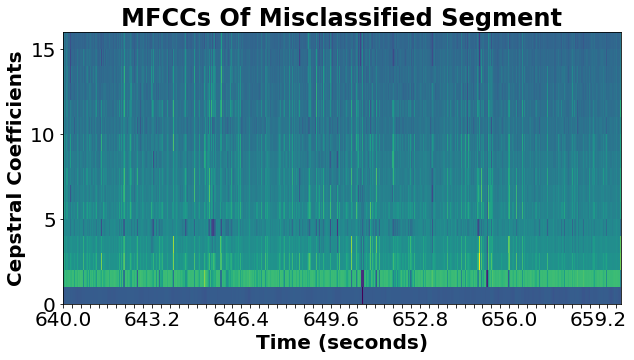

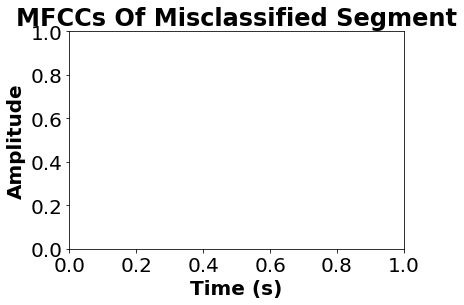

In [29]:
# Plot the mfccs for error segments

def plot_mfcc(data_mfcc, start):
    fig = plt.figure(figsize=(10, 5))
    # Show the x-ticks in seconds
    #plt.xticks(np.arange(0, len(data_mfcc[0]), 10), np.arange(start, len(data_mfcc[0])*0.032 + start, 10*0.032))
    # Round the x-ticks to 2 decimals
    plt.xticks(np.arange(0, len(data_mfcc[0]), 10), np.round(np.arange(start, len(data_mfcc[0])*0.032 + start, 10*0.032),2))
    # only show every 10th tick
    for i, label in enumerate(fig.axes[0].get_xticklabels()):
        if i % 10 != 0:
            label.set_visible(False)
    
    plt.pcolormesh((data_mfcc),shading='auto')
    plt.ylabel('Mel Cepstrum Coefficients')
    plt.xlabel('Time [sec]')
    
    plt.title('MFCCs Of Misclassified Segment', fontweight='bold')
    plt.xlabel('Time (seconds)', fontweight='bold')
    plt.ylabel('Cepstral Coefficients', fontweight='bold')
    plt.show()

# Linear scale for plotting, with 32 ms space between each mfcc
mfccs = data_mfcc_ear1

time = np.linspace(0, len(mfccs)*0.032, len(mfccs))

plt.figure(figsize=(10,6))


# Calc segment length in mfccs and position in mfccs
pos_in_secs = 640
#pos_in_secs = 465
mfccs_pr_sec = 1/0.032
seg_len = int(20*mfccs_pr_sec)
seg_pos = int(pos_in_secs*mfccs_pr_sec)


# Use plot_mfcc() to plot the mfccs of a segment
plot_mfcc(np.transpose(mfccs[seg_pos:seg_pos+seg_len]), pos_in_secs)

#plt.xlim(65,85)
#plt.xlim(210,230)

plt.title('MFCCs Of Misclassified Segment', fontweight='bold')
plt.xlabel('Time (s)', fontweight='bold')
plt.ylabel('Amplitude', fontweight='bold')

plt.show()

In [ ]:
# Find all the places where the predictions are wrong
from scipy.io.wavfile import write
amplitude = np.iinfo(np.int16).max

wrong_preds = []
error_seg_len = []
for i in range(len(preds_list_ear1)): # Find the locations of the error segments
    if preds_list_ear1[i] != labels_mfcc[i] and labels_mfcc[i] != -1: # Only include if it's a new segment
        if preds_list_ear1[i-1] == labels_mfcc[i-1]:
            wrong_preds.append(i)
            j = i
            
            while preds_list_ear1[j] != labels_mfcc[j]: # Find the length of the misclassified segment
                j += 1 
            error_seg_len.append(j-i)    
            
            # Save a file
            if (j - i) > 50:
                print(i)
                print(j)
                print(int(i*(50000*0.032)))
                print(int(j*(50000*0.032)))
                test_sig = data_ear_1[int(i*(50000*0.032)):int(j*(50000*0.032))]
                print(test_sig)
                test_sig = (test_sig - np.mean(test_sig)) / np.std(test_sig)
                test_sig = test_sig/max(abs(test_sig))
                test_sig = test_sig* amplitude
                write(f"error_sound_files/error_pred_{preds_list_ear1[i]}_y_{labels_mfcc[i]}_len_{j-i}.wav", 50000, test_sig.astype(np.int16))
        
        
print(f"Number of wrong predictions: {len(wrong_preds)}")

for i in range(len(wrong_preds)):
    print(f"Position: {wrong_preds[i]}, Length: {error_seg_len[i]}")


118
180
188800
288000
[-0.697467   -0.6974694  -0.69748646 ... -0.69366026 -0.69365263
 -0.69364744]
691
753
1105600
1204800
[-0.6937588  -0.69375265 -0.69375926 ... -0.7073139  -0.7073167
 -0.70731246]
1774
1902
2838400
3043200
[-0.72774434 -0.72775334 -0.7277718  ... -0.73283476 -0.73284566
 -0.7328836 ]
3480
3587
5568000
5739200
[-0.7389866  -0.7389913  -0.73898137 ... -0.7067827  -0.7067964
 -0.70680636]
3735
3808
5976000
6092800
[-0.7407791  -0.7407839  -0.74079096 ... -0.7331006  -0.7331096
 -0.73312193]
4271
4349
6833600
6958400
[-0.7322311  -0.73222065 -0.73222256 ... -0.7684086  -0.7683408
 -0.76826835]
4961
5067
7937600
8107200
[-0.7513362  -0.75138026 -0.7514125  ... -0.7594696  -0.7594947
 -0.75952315]
5874
6263
9398400
10020800
[-0.7594952  -0.7594976  -0.7595109  ... -0.7534571  -0.75348127
 -0.7535007 ]
7057
7118
11291200
11388800
[-0.76409477 -0.7640692  -0.76406157 ... -0.77253664 -0.772548
 -0.772558  ]
8116
8273
12985600
13236800
[-0.7708579  -0.7709119  -0.77096164 

In [ ]:
error_index = 0

Segment position: 4
Segment position: 100


NameError: name 'data_mfcc' is not defined

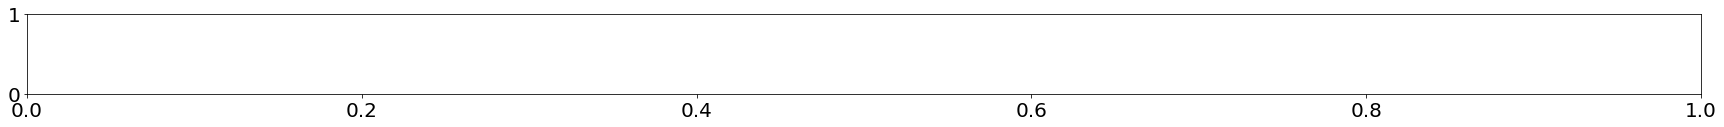

In [ ]:
#Plot segments where the predictions are wrong
error_index += 1

segment_len = 100
segment_pos = wrong_preds[error_index]
print(f"Segment position: {segment_pos}")

if segment_pos < segment_len: segment_pos = segment_len # Make sure the segment is not before the start of the data
    
print(f"Segment position: {segment_pos}")

t1 = np.linspace(0, 2*segment_len*0.032, segment_len*2) # Create an acurate time vector for mfcc windows
t2 = np.linspace(0, 2*segment_len*0.032, int(segment_len*2*0.032*50000)) # Create an acurate time vector for raw data

fig = plt.figure(figsize=(30, 5))
plt.subplot(3,1,1)

plt.pcolormesh((data_mfcc[segment_pos -segment_len: segment_pos + segment_len].transpose()),shading='auto')
plt.ylabel('Mel Cepstrum Coefficients')
plt.xlabel('MFCC Windows')

plt.subplot(3,1,2)

plt.plot(t2,data_ear_1[segment_pos*1600 -segment_len*1600: segment_pos*1600 + segment_len*1600])
plt.ylabel('Raw Signal')
plt.xlabel('Time [sec]')

plt.subplot(3,1,3)

plt.plot(t1,labels_mfcc[segment_pos -segment_len: segment_pos + segment_len])
plt.ylabel('Actual Label')
plt.xlabel('Time [sec]')
fig.set_figheight(15)


plt.plot(t1,preds_list[segment_pos -segment_len: segment_pos + segment_len])
plt.ylabel('Predicted label')
plt.xlabel('Time [sec]')

plt.show()
